<a href="https://colab.research.google.com/github/congltk1234/Fashion_Items_Classification/blob/main/FashionMNIST/CustomCNN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow_datasets

import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()

train_size = int(0.8 * num_train_examples)
val_size = int(0.2 * num_train_examples)

val_dataset = train_dataset.skip(train_size)
val_dataset = val_dataset.cache()
train_dataset = train_dataset.take(train_size)

test_dataset  =  test_dataset.cache()

In [21]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing


def my_CNN(input_shape=(28, 28, 1)):
    model = tf.keras.Sequential([
        # Input shape
        tf.keras.layers.Input(shape=input_shape),  # shape=(28,28,1)

        # Layer 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),

        # Layer 2
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        # Layer 3
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Layer 4
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        # Layer 5
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # Layer 6
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # Output layer
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999 ),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [9]:
# Model summary
model=my_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0

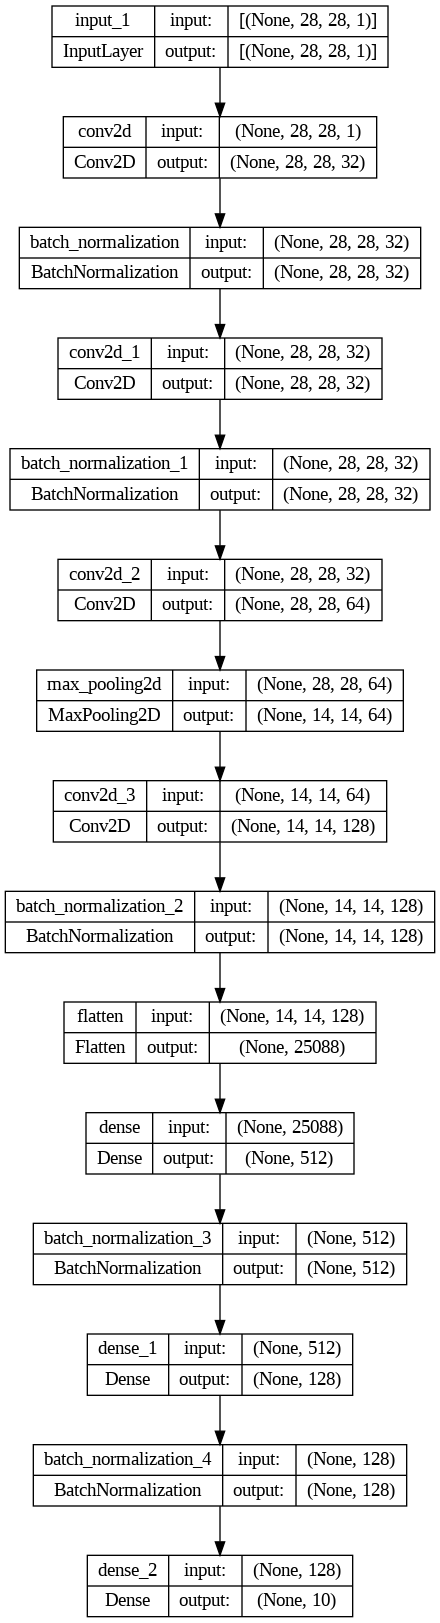

In [10]:
from keras.utils import plot_model
plot_model(model, to_file='LeNet5.png', show_shapes=True, show_layer_names=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.2 MB/s eta 0:00:00


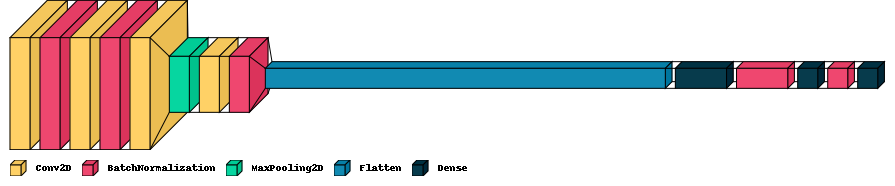

In [11]:
!pip install visualkeras

import visualkeras
visualkeras.layered_view(model, legend=True)

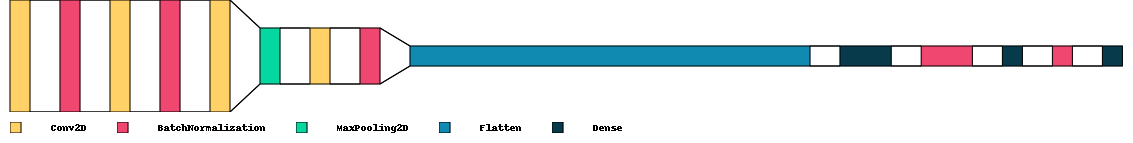

In [12]:
visualkeras.layered_view(model, legend=True, draw_volume=False,spacing=30)

In [13]:
BATCH_SIZE = 32

train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE)

In [22]:
epoch = 50

# Build model
model = my_CNN()

from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'custom_epoch_{epoch:02d}.h5'
model_checkpoint = ModelCheckpoint(checkpoint_filepath,
                                   save_weights_only=True,
                                   period=10,  # Save weights every 50 epochs
                                   verbose=1)

import time
# get the start time
st = time.time()
history = model.fit(train_dataset, epochs=epoch,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    validation_data=val_dataset,
                    validation_steps=len(val_dataset) // BATCH_SIZE,
                    callbacks=[model_checkpoint],
                    verbose=True)


print('Execution time:', time.time() - st, 'seconds')

Epoch 1/50
1875/1875 [==============================] - 33s 15ms/step - loss: 0.4972 - accuracy: 0.8280 - val_loss: 0.2792 - val_accuracy: 0.8920
Epoch 2/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3150 - accuracy: 0.8882 - val_loss: 0.2297 - val_accuracy: 0.9062
Epoch 3/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2678 - accuracy: 0.9044 - val_loss: 0.1916 - val_accuracy: 0.9375
Epoch 4/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2574 - accuracy: 0.9088 - val_loss: 0.1722 - val_accuracy: 0.9347
Epoch 5/50
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2128 - accuracy: 0.9245 - val_loss: 0.1403 - val_accuracy: 0.9545
Epoch 6/50
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1960 - accuracy: 0.9307 - val_loss: 0.1753 - val_accuracy: 0.9403
Epoch 7/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1732 - accuracy: 0.9381 - val_loss: 0.1753 -

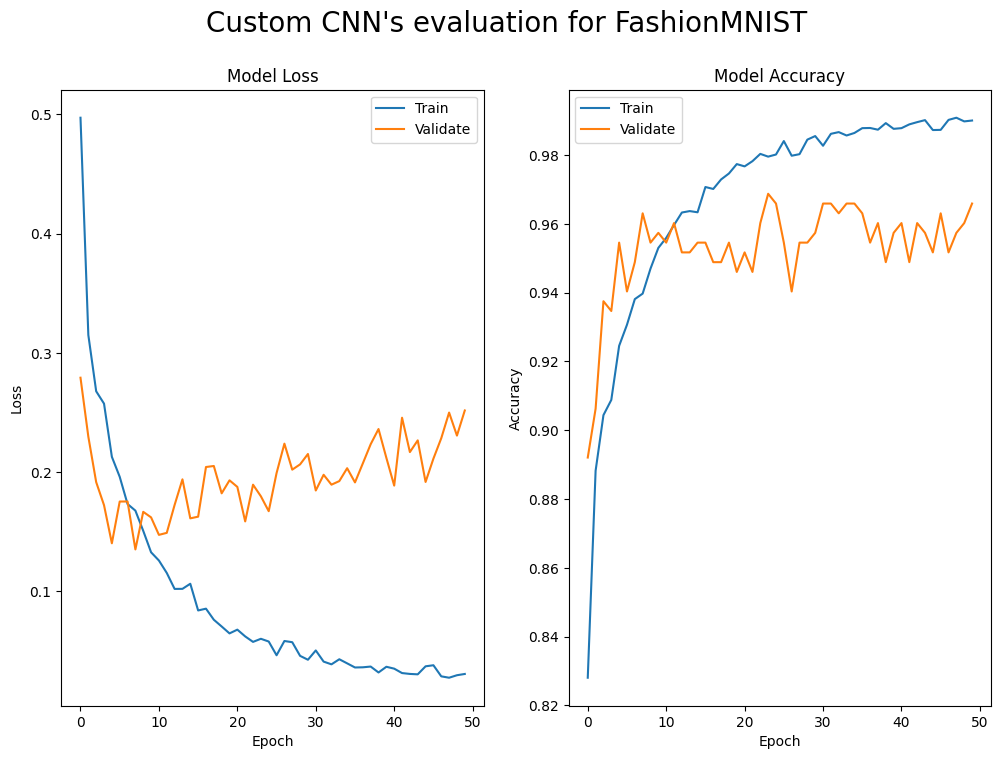

In [23]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2, figsize=(12,8))
fig.suptitle("Custom CNN's evaluation for FashionMNIST ",fontsize=20)
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train','Validate'])


axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train','Validate'])
plt.show()

In [24]:

import json

# Convert and write JSON object to file
# with open("50epoch_custom.json", "w") as outfile:
#     json.dump(history.history, outfile)

import tqdm
testX = []
testY = []
for (image, label) in tqdm.tqdm(test_dataset.take(10000)):
    image = tf.convert_to_tensor(image)
    testX.append(image)
    testY.append(label)

testX = np.array(testX)
testY = np.array(testY)

testX.shape, testY.shape

100%|██████████| 10000/10000 [00:03<00:00, 3219.01it/s]


((10000, 28, 28, 1), (10000,))

<ipython-input-25-c440bd798a2a>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testX, num_test_examples // BATCH_SIZE)


              precision    recall  f1-score   support

 T-shirt/top       0.89      0.91      0.90      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.92      0.92      0.92      1000
       Dress       0.93      0.95      0.94      1000
        Coat       0.89      0.93      0.91      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.85      0.78      0.81      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



<Figure size 1000x300 with 0 Axes>

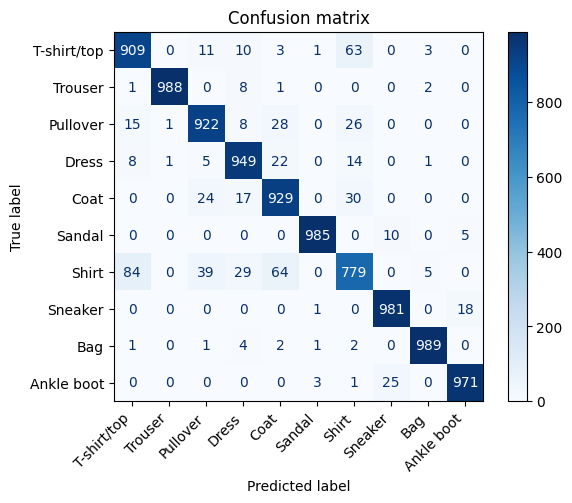

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.91      0.90      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.92      0.92      0.92      1000
       Dress       0.93      0.95      0.94      1000
        Coat       0.89      0.93      0.91      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.85      0.78      0.81      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

0.9402
0.9398169075963424


In [25]:
from sklearn.metrics import classification_report


# Load the best weights after training
Y_pred = model.predict_generator(testX, num_test_examples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(testY, y_pred, target_names=class_names))


from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,3))

disp = ConfusionMatrixDisplay.from_predictions(
    testY, y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Confusion matrix")

# print(disp.confusion_matrix)
# Rotate x-axis labels
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')

plt.show()


from sklearn.metrics import classification_report
print(classification_report(testY, y_pred, target_names=class_names))
from sklearn.metrics import accuracy_score
print(accuracy_score(testY, y_pred))
from sklearn.metrics import f1_score
print(f1_score(testY, y_pred, average='weighted'))

<ipython-input-26-39b06bb28ecb>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(testX, num_test_examples // BATCH_SIZE)


              precision    recall  f1-score   support

 T-shirt/top       0.93      0.84      0.88      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.91      0.90      0.90      1000
       Dress       0.93      0.92      0.92      1000
        Coat       0.85      0.94      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.79      0.80      0.79      1000
     Sneaker       0.96      0.99      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



<Figure size 1000x300 with 0 Axes>

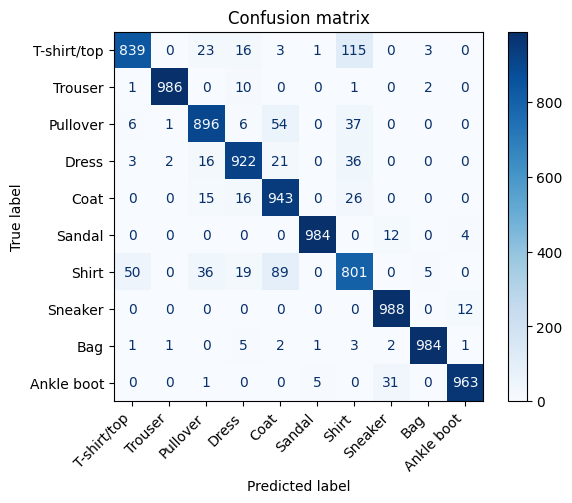

              precision    recall  f1-score   support

 T-shirt/top       0.93      0.84      0.88      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.91      0.90      0.90      1000
       Dress       0.93      0.92      0.92      1000
        Coat       0.85      0.94      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.79      0.80      0.79      1000
     Sneaker       0.96      0.99      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

0.9306
0.9307302417716795


In [26]:
# @title 10 epochs
from keras.models import load_model

# Load the entire model (including architecture and optimizer state) from the checkpoint file
checkpoint_filepath = '/content/custom_epoch_10.h5'   # @param {type:"string"}
# Build model
new_model = my_CNN()

# Load the entire model from the saved file
new_model.load_weights(checkpoint_filepath)

from sklearn.metrics import classification_report


# Load the best weights after training
Y_pred = new_model.predict_generator(testX, num_test_examples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(testY, y_pred, target_names=class_names))


from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,3))

disp = ConfusionMatrixDisplay.from_predictions(
    testY, y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Confusion matrix")

# print(disp.confusion_matrix)
# Rotate x-axis labels
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')

plt.show()


from sklearn.metrics import classification_report
print(classification_report(testY, y_pred, target_names=class_names))
from sklearn.metrics import accuracy_score
print(accuracy_score(testY, y_pred))
from sklearn.metrics import f1_score
print(f1_score(testY, y_pred, average='weighted'))

<ipython-input-27-370be2c1322e>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(testX, num_test_examples // BATCH_SIZE)


              precision    recall  f1-score   support

 T-shirt/top       0.88      0.89      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.89      0.92      0.90      1000
       Dress       0.92      0.95      0.93      1000
        Coat       0.90      0.90      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.83      0.78      0.80      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.99      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



<Figure size 1000x300 with 0 Axes>

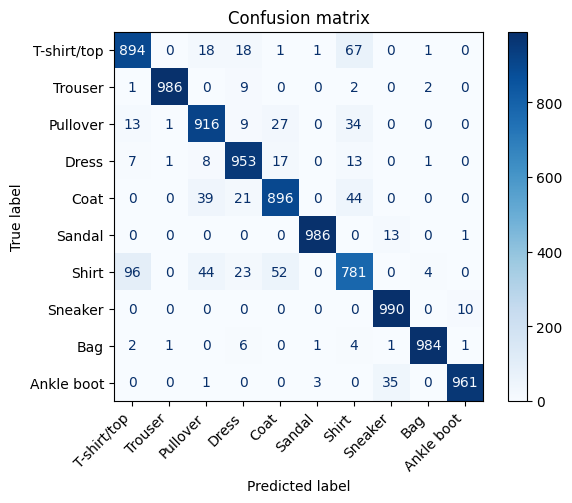

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.89      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.89      0.92      0.90      1000
       Dress       0.92      0.95      0.93      1000
        Coat       0.90      0.90      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.83      0.78      0.80      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.99      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

0.9347
0.9344552281077758


In [27]:
# @title 20 epochs
from keras.models import load_model

# Load the entire model (including architecture and optimizer state) from the checkpoint file
checkpoint_filepath = '/content/custom_epoch_20.h5'   # @param {type:"string"}
# Build model
new_model = my_CNN()

# Load the entire model from the saved file
new_model.load_weights(checkpoint_filepath)

from sklearn.metrics import classification_report


# Load the best weights after training
Y_pred = new_model.predict_generator(testX, num_test_examples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(testY, y_pred, target_names=class_names))


from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,3))

disp = ConfusionMatrixDisplay.from_predictions(
    testY, y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Confusion matrix")

# print(disp.confusion_matrix)
# Rotate x-axis labels
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')

plt.show()


from sklearn.metrics import classification_report
print(classification_report(testY, y_pred, target_names=class_names))
from sklearn.metrics import accuracy_score
print(accuracy_score(testY, y_pred))
from sklearn.metrics import f1_score
print(f1_score(testY, y_pred, average='weighted'))

# Dự đoán

1/1 [==============================] - 0s 28ms/step
Predict: Bag


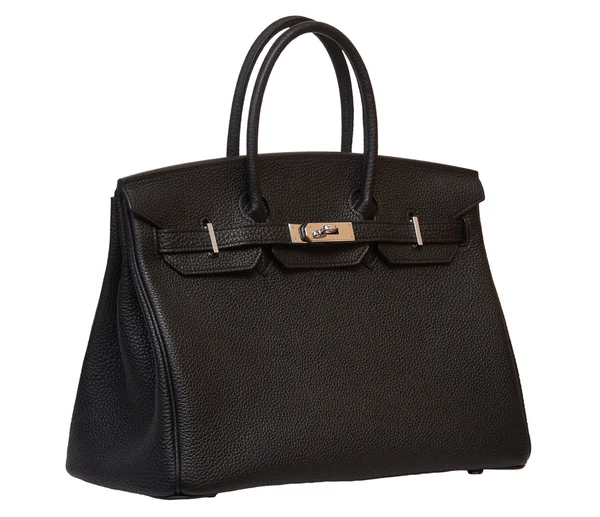

In [44]:
#@title Bag (url)
from PIL import Image
INPUT_IMAGE_URL = "https://st2.depositphotos.com/3588765/6055/i/450/depositphotos_60551401-stock-photo-womens-black-leather-handbag.jpg" #@param {type:"string"}
# Tải về
!wget -q -O input.jpg $INPUT_IMAGE_URL



def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new("L", (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new("L", (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


# Đọc ảnh bằng thư viện Pillow
image = Image.open('input.jpg')
image.thumbnail((28,28))  # Resize về 32x32
image = expand2square(image, (0))
new_img = np.array(image)
# .convert('L')
# Predict
predict_result = model.predict(new_img.reshape(-1, 28, 28, 1))
predict_result = np.argmax(predict_result, axis=1)
print('Predict:', class_names[predict_result[0]])


# hiển thị ra
from IPython.display import Image
demo_img = Image(filename='input.jpg',width=250, height=250 )

display(demo_img)

1/1 [==============================] - 0s 29ms/step
Predict: Ankle boot


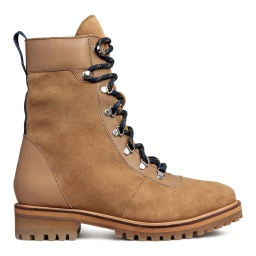

In [49]:
#@title Jacket (url)
from PIL import Image
# INPUT_IMAGE_URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcStdgQVIlrWPRzbZJCNxE7et4joqQUIxKjKil0i-AtwA3JKjOxf8hZF3xEgfsjxl8Vz2bs&usqp=CAU" #@param {type:"string"}
# # Tải về
# !wget -q -O input.jpg $INPUT_IMAGE_URL



def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new("L", (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new("L", (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


# Đọc ảnh bằng thư viện Pillow
image = Image.open('/content/0420049002.jpg')
image.thumbnail((28,28))  # Resize về 32x32
image = expand2square(image, (0))
new_img = np.array(image)/255
# .convert('L')
# Predict
predict_result = model.predict(new_img.reshape(-1, 28, 28, 1))
predict_result = np.argmax(predict_result, axis=1)
print('Predict:', 'Ankle boot')


# hiển thị ra
from IPython.display import Image
demo_img = Image(filename='/content/0420049002.jpg',width=250, height=250 )

display(demo_img)